In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

from hydroDL.data import dbVeg

# Screening MODIS data
This file screens MODIS csv data for only the highest quality data.

### Determine bitmaps we want to screen for
The bitmaps are 32 digits long, where the 2 digits at either end determine MODLAND QA bits, atmospheric correction, and adjacency correction. The middle 28 bits determine the quality of bands 1-7. I want to screen just so the 7 bands are highest quality and see what is leftover with regards to 3 other variables just mentioned.

See https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MYD09GA#bands for more details

In [298]:
# collect unique bitmaps from all files
path ='/Users/andyhuynh/Documents/lfmc/data/RS/MODIS/'
sat_dirs = os.listdir(path)

bitmaps = set({})
for sat_dir in sat_dirs:
    sat_path = os.path.join(path, sat_dir)
    if not os.path.isdir(sat_path):
        continue
    for file in os.listdir(sat_path):
        file_path = os.path.join(sat_path, file)
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(file_path)
        vals = df.QC_500m.unique()
        for val in vals:
            if val != val:
                continue
            bitmaps.add('{0:b}'.format(int(val)))

In [299]:
# update all bitmaps to have 32 digits
corrected_bitmaps = []
for b in bitmaps:
    while len(b) < 32:
        b = '0' + b
    corrected_bitmaps.append(b)
bitmaps = corrected_bitmaps

In [300]:
# only keep bitmaps where the bands 1-7 are highest quality (bits 2-30) 
# see https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MYD09GA#bands
new_bitmaps = []
for b in bitmaps:
    if int(b[2:30]) == 0:
        new_bitmaps.append(b)     

In [301]:
new_bitmaps

['01000000000000000000000000000000']

In [302]:
# only one bitmap where bands 1-7 of highest quality, screen for this value
int(new_bitmaps[0], 2)

1073741824

### Screen MODIS data for highest quality

In [354]:
# create new directories
new_path = '/Users/andyhuynh/Documents/lfmc/data/RS/MODIS_quality/'

if not os.path.exists(new_path):
    os.mkdir(new_path)

path ='/Users/andyhuynh/Documents/lfmc/data/RS/MODIS/'
sat_dirs = os.listdir(path)
for sat_dir in sat_dirs:
    sat_path = os.path.join(path, sat_dir)
    if os.path.isdir(sat_path):
        new_sat_path = os.path.join(new_path, sat_dir)
        if not os.path.exists(new_sat_path):
            os.mkdir(new_sat_path)

In [355]:
df_lens = []
quality_df_lens = []

bitmaps = set({})
for sat_dir in sat_dirs:
    sat_path = os.path.join(path, sat_dir)
    if not os.path.isdir(sat_path):
        continue
    for file in os.listdir(sat_path):
        file_path = os.path.join(sat_path, file)
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(file_path)
        quality_df = df[df.QC_500m == 1073741824]
        save_path = os.path.join(new_path, sat_dir, file)
        quality_df.to_csv(save_path, index=False)
        df_lens.append(len(df))
        quality_df_lens.append(len(quality_df))

In [356]:
np.mean(df_lens)

2962.5

In [357]:
np.mean(quality_df_lens)

1811.1119402985075

In [358]:
np.mean(df_lens) - np.mean(quality_df_lens)

1151.3880597014925

In [463]:
np.mean(quality_df_lens) / np.mean(df_lens)

0.6113458026324076

### Compare Aqua and Terra satellite data 

In [46]:
rho = 45 # init rho
dataName = 'singleDaily' # init dataName
df = dbVeg.DataFrameVeg(dataName) 

terra_bands = ['mod_b1', 'mod_b2', 'mod_b3', 'mod_b4', 'mod_b5', 'mod_b6', 'mod_b7']
aqua_bands = ['myd_b1', 'myd_b2', 'myd_b3', 'myd_b4', 'myd_b5', 'myd_b6', 'myd_b7']

i_terra = [df.varX.index(var) for var in terra_bands]
i_aqua = [df.varX.index(var) for var in aqua_bands]

terra_df = df.x[:, :, i_terra]
aqua_df = df.x[:, :, i_aqua]

In [47]:
site = 139
band = 5
keep_dates = ~np.isnan(df.y[:, site, 0])

In [48]:
terra_ts = terra_df[:, site, band]
aqua_ts = aqua_df[:, site, band]
dates = df.t[:]

# terra_ts = terra_df[keep_dates, site, band]
# aqua_ts = aqua_df[keep_dates, site, band]
# dates = df.t[keep_dates]
# np.sum(keep_dates)

In [49]:
modis_dates = ~np.isnan(terra_ts) & ~np.isnan(aqua_ts)
terra_ts = terra_ts[modis_dates] / 10000
aqua_ts = aqua_ts[modis_dates] / 10000
dates = dates[modis_dates]

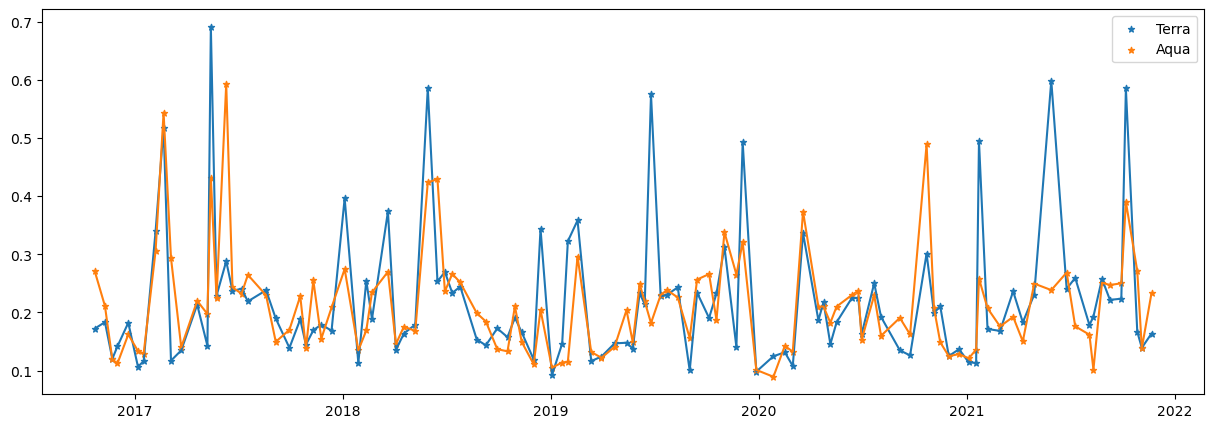

In [50]:
plt.figure(figsize=(15,5))
end = len(terra_ts) - 1
interval = 5
plt.scatter(dates[:end:interval], terra_ts[:end:interval], marker='*', s=20)
plt.scatter(dates[:end:interval], aqua_ts[:end:interval], marker='*', s=20)
plt.plot(dates[:end:interval], terra_ts[:end:interval])
plt.plot(dates[:end:interval], aqua_ts[:end:interval])
plt.legend(['Terra', 'Aqua'])
plt.show()

In [51]:
diff1 = terra_df - aqua_df
np.nanmean(diff1)

-73.57210407663322

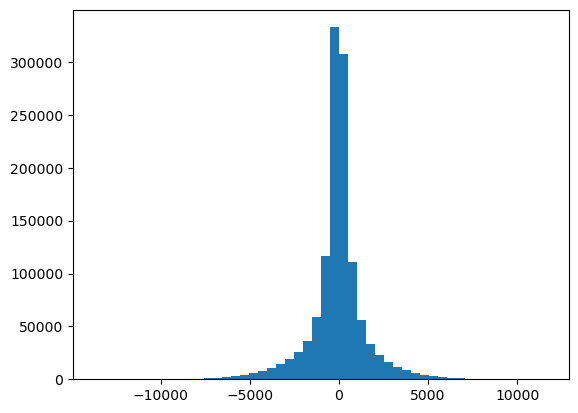

In [395]:
plt.hist(diff1.flatten(), bins=50)
plt.show()

### Trying with raw data

In [371]:
path_qual = '/Users/andyhuynh/Documents/lfmc/data/RS/MODIS_quality/MOD09GA-500m/N0015.csv'
df_qual = pd.read_csv(path_qual)

path_poor = '/Users/andyhuynh/Documents/lfmc/data/RS/MODIS/MOD09GA-500m/N0015.csv'
df_poor = pd.read_csv(path_poor)

In [372]:
len(df_qual)

2773

In [373]:
len(df_poor)

2960